# Персонализированные предложения для увеличения покупательской активности в интернет-магазине 'В один клик'


В рамках проекта необходимо разработать модель для предсказания вероятности снижения покупательской активности клиентов интернет-магазина "В один клик" в течение следующих трех месяцев. Затем на основе данных моделирования и информации о прибыльности клиентов провести сегментацию покупателей и предложить персонализированные предложения для увеличения их покупательской активности.

План работы:

* Загрузка данных.
* Предобработка данных.
* Исследовательский анализ данных.
* Объединение таблиц.
* Корреляционный анализ.
* Использование пайплайнов:
* Подготовка данных с использованием ColumnTransformer.
* Обучение моделей: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и SVC(). Подбор гиперпараметров для каждой модели с использованием выбранной метрики.
* Выбор лучшей модели.
* Анализ важности признаков с помощью метода SHAP.
* Сегментация покупателей:
* Выполнение сегментации покупателей.
* Анализ выбранной группы покупателей.
* Предложения по увеличению покупательской активности.
* Выводы о сегментах и предложениях.

## Загрузка данных

In [1]:
!pip install shap -q
!pip install phik -q
!pip install matplotlib==3.5.1 -q
!pip install scikit-learn==1.1.3 -q # -q убирает необязательные выводы в командах Linux

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import shap
# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix, accuracy_score, recall_score, precision_score
import phik
import warnings
warnings.filterwarnings('ignore')

In [3]:
market_file = pd.read_csv('/datasets/market_file.csv')
market_money = pd.read_csv('/datasets/market_money.csv')
market_time = pd.read_csv('/datasets/market_time.csv')
money = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')

In [4]:
market_file.head()

id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   
3  215351                 Снизилась   стандартт                 да   
4  215352                 Снизилась   стандартт                нет   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   
4     Товары для детей                                    3   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5  
3                                   0               6                 4  
4                                   2               3                 2

In [5]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [6]:
market_money.head()

id               Период  Выручка
0  215348  препредыдущий_месяц      0.0
1  215348        текущий_месяц   3293.1
2  215348     предыдущий_месяц      0.0
3  215349  препредыдущий_месяц   4472.0
4  215349        текущий_месяц   4971.6

In [7]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [8]:
market_time.head()

id            Период  минут
0  215348     текущий_месяц     14
1  215348  предыдцщий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдцщий_месяц     12
4  215350     текущий_месяц     13

In [9]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [10]:
money.head()

id  Прибыль
0  215348     0.98
1  215349     4.16
2  215350     3.13
3  215351     4.87
4  215352     4.21

In [11]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB



Данные представлены в нескольких таблицах, содержащих информацию о поведении покупателей на сайте интернет-магазина, их взаимодействии с компанией, а также о финансовых показателях магазина. 

1. **market_file.csv**: 
   - **id**: Уникальный идентификатор покупателя в базе данных.
   - **Покупательская активность**: Категория, отражающая изменение активности покупателя ("снизилась" или "прежний уровень").
   - **Тип сервиса**: Уровень обслуживания покупателя (например, "премиум" или "стандарт").
   - **Разрешить сообщать**: Разрешение на получение дополнительных предложений о товарах.
   - **Маркет_актив_6_мес**: Среднее количество маркетинговых коммуникаций в месяц за последние 6 месяцев.
   - **Маркет_актив_тек_мес**: Количество маркетинговых коммуникаций в текущем месяце.
   - **Длительность**: Время с момента регистрации покупателя на сайте.
   - **Акционные_покупки**: Доля покупок по акции от общего числа покупок за последние 6 месяцев.
   - **Популярная_категория**: Самая популярная категория товаров у покупателя за последние 6 месяцев.
   - **Средний_просмотр_категорий_за_визит**: Среднее количество категорий, просматриваемых покупателем за один визит за последний месяц.
   - **Неоплаченные_продукты_штук_квартал**: Общее число неоплаченных товаров в корзине за последние 3 месяца.
   - **Ошибка_сервиса**: Число сбоев, возникших у покупателя во время посещения сайта.
   - **Страниц_за_визит**: Среднее количество страниц, просмотренных покупателем за один визит на сайт за последние 3 месяца.

2. **market_money.csv**:
   - **id**: Уникальный идентификатор покупателя в базе данных.
   - **Период**: Название периода, в котором фиксируется выручка.
   - **Выручка**: Сумма выручки за указанный период.

3. **market_time.csv**:
   - **id**: Уникальный идентификатор покупателя в базе данных.
   - **Период**: Название периода, в котором фиксируется общее время.
   - **минут**: Значение времени, проведенного покупателем на сайте в минутах.

4. **money.csv**:
   - **id**: Уникальный идентификатор покупателя в базе данных.
   - **Прибыль**: Среднемесячная прибыль от продаж для каждого покупателя за последние 3 месяца.

## Предобработка данных

In [12]:
market_file.isna().sum()

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

In [13]:
market_file.duplicated().sum()

0

In [14]:
market_money.isna().sum()

id         0
Период     0
Выручка    0
dtype: int64

In [15]:
market_money.duplicated().sum()

0

In [16]:
market_time.isna().sum()

id        0
Период    0
минут     0
dtype: int64

In [17]:
market_time.duplicated().sum()

0

In [18]:
money.isna().sum()

id         0
Прибыль    0
dtype: int64

In [19]:
money.duplicated().sum()

0

In [20]:
market_file['Покупательская активность'].value_counts()

Прежний уровень    802
Снизилась          498
Name: Покупательская активность, dtype: int64

In [21]:
market_file['Тип сервиса'].value_counts()

стандарт     914
премиум      376
стандартт     10
Name: Тип сервиса, dtype: int64

In [22]:
market_file['Тип сервиса'] = market_file['Тип сервиса'].replace({'стандартт': 'стандарт'})

In [23]:
market_file['Популярная_категория'].value_counts()

Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: Популярная_категория, dtype: int64

In [24]:
market_money['Период'].value_counts()

препредыдущий_месяц    1300
текущий_месяц          1300
предыдущий_месяц       1300
Name: Период, dtype: int64

In [25]:
market_time['Период'].value_counts()

предыдцщий_месяц    1300
текущий_месяц       1300
Name: Период, dtype: int64

Предобработка данных. Краткий вывод

В процессе предобработки данных были выполнены следующие шаги:

* Обнаружены и обработаны неявные дубликаты в столбце 'Тип сервиса'.


## Исследовательский анализ данных

### market_file.csv

In [26]:
market_file.describe()

id  Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  \
count    1300.000000         1300.000000           1300.000000   1300.000000   
mean   215997.500000            4.253769              4.011538    601.898462   
std       375.421985            1.014814              0.696868    249.856289   
min    215348.000000            0.900000              3.000000    110.000000   
25%    215672.750000            3.700000              4.000000    405.500000   
50%    215997.500000            4.200000              4.000000    606.000000   
75%    216322.250000            4.900000              4.000000    806.000000   
max    216647.000000            6.600000              5.000000   1079.000000   

       Акционные_покупки  Средний_просмотр_категорий_за_визит  \
count        1300.000000                           1300.00000   
mean            0.319808                              3.27000   
std             0.249843                              1.35535   
min             0.000000                              1.00000   
25%             0.170000                              2.00000   
50%             0.240000                              3.00000   
75%             0.300000                              4.00000   
max             0.990000                              6.00000   

       Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
count                         1300.000000     1300.000000       1300.000000  
mean                             2.840000        4.185385          8.176923  
std                              1.971451        1.955298          3.978126  
min                              0.000000        0.000000          1.000000  
25%                              1.000000        3.000000          5.000000  
50%                              3.000000        4.000000          8.000000  
75%                              4.000000        6.000000         11.000000  
max                             10.000000        9.000000         20.000000

In [27]:
(
    market_file[['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит']]
    .quantile([0.0012, 0.01, .5, .99, .9988]) # выбираем размах в 0,9976 квантилей 
    .style.format("{:,.2f}")
)

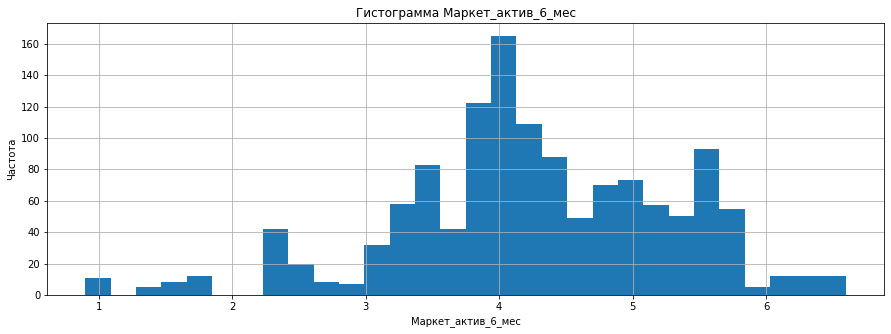

In [28]:
market_file['Маркет_актив_6_мес'].hist(bins=30, figsize=(15,5))
plt.title('Гистограмма Маркет_актив_6_мес')
plt.xlabel('Маркет_актив_6_мес')
plt.ylabel('Частота')
plt.show()

Гистограмма переменной "Маркет_актив_6_мес" показывает, что большинство значений находится в диапазоне от примерно 3.7 до 4.9. Среднее значение составляет около 4.25, со стандартным отклонением примерно 1.01. Распределение похоже на нормальное с некоторой асимметрией вправо.

In [29]:
market_file['Маркет_актив_тек_мес'].describe()

count    1300.000000
mean        4.011538
std         0.696868
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: Маркет_актив_тек_мес, dtype: float64

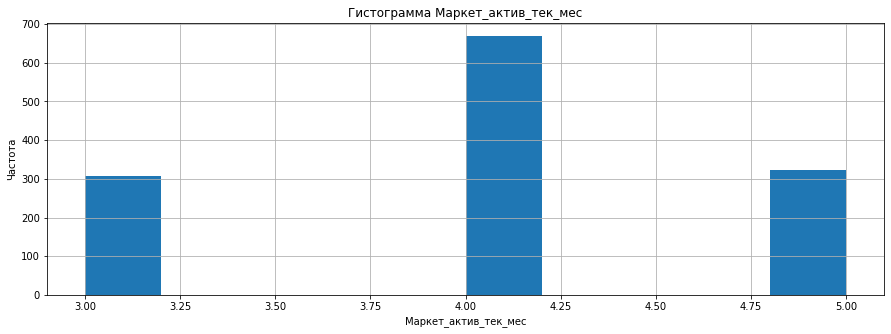

In [30]:
market_file['Маркет_актив_тек_мес'].hist(bins=10, figsize=(15,5))
plt.title('Гистограмма Маркет_актив_тек_мес')
plt.xlabel('Маркет_актив_тек_мес')
plt.ylabel('Частота')
plt.show()

Гистограмма показывает распределение переменной "Маркет_актив_тек_мес" в данных. Большинство значений сосредоточены вокруг значения 4, что подтверждается средним значением, равным приблизительно 4.01. Распределение скошено вправо, с наименьшим значением в районе 3 и наибольшим около 5.

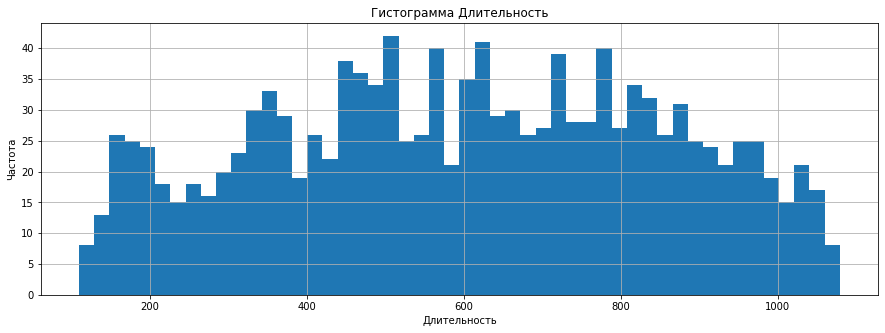

In [31]:
market_file['Длительность'].hist(bins=50, figsize=(15,5))
plt.title('Гистограмма Длительность')
plt.xlabel('Длительность')
plt.ylabel('Частота')
plt.show()

Гистограмма переменной "Длительность" показывает распределение продолжительности событий. Средняя продолжительность составляет примерно 601.9 единицу времени, со стандартным отклонением около 249.9. Большинство значений сосредоточены вокруг медианного значения, равного 606 единицам времени. Распределение имеет форму, близкую к нормальной, с пиком в области 600-800 единиц времени. Вариация продолжительности относительно высока, что подтверждается значительным разбросом значений от минимального (110) до максимального (1079).

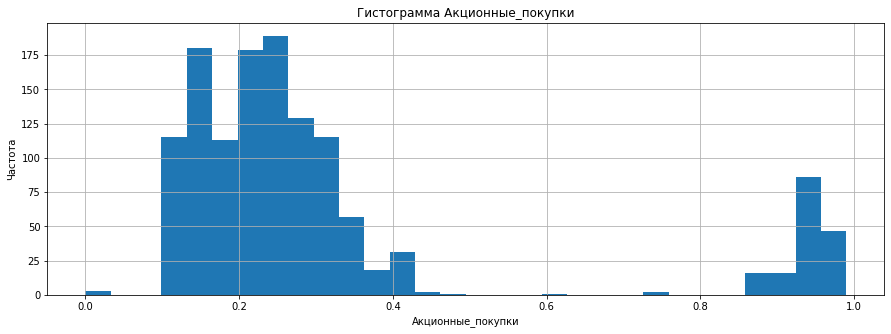

In [32]:
market_file['Акционные_покупки'].hist(bins=30, figsize=(15,5))
plt.title('Гистограмма Акционные_покупки')
plt.xlabel('Акционные_покупки')
plt.ylabel('Частота')
plt.show()

Гистограмма переменной "Акционные_покупки" показывает распределение доли акционных покупок от общего числа покупок. Среднее значение составляет около 0.32, а стандартное отклонение около 0.25. Большинство значений сосредоточены вокруг значения 0.24-0.30, что подтверждается медианным значением, равным 0.24. Распределение скошено вправо, с наименьшим значением в районе 0 и наибольшим около 1. Вариация в доле акционных покупок относительно высока, что подтверждается значительным разбросом значений от минимального (0) до максимального (0.99).

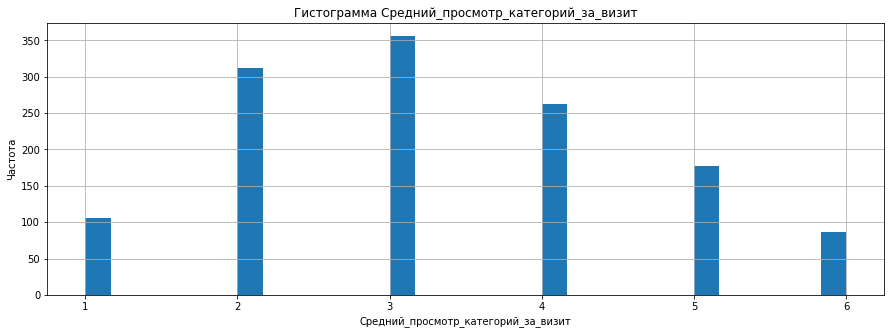

In [33]:
market_file['Средний_просмотр_категорий_за_визит'].hist(bins=30, figsize=(15,5))
plt.title('Гистограмма Средний_просмотр_категорий_за_визит')
plt.xlabel('Средний_просмотр_категорий_за_визит')
plt.ylabel('Частота')
plt.show()

Гистограмма переменной "Средний_просмотр_категорий_за_визит" отображает распределение среднего числа просмотренных категорий за один визит. Среднее значение составляет около 3.27, а стандартное отклонение около 1.36. Большинство значений сосредоточены вокруг значения 2-4, что подтверждается медианным значением, равным 3. Распределение имеет форму, близкую к нормальной, с пиком в области 2-4. Вариация в среднем числе просмотренных категорий за визит относительно средняя.

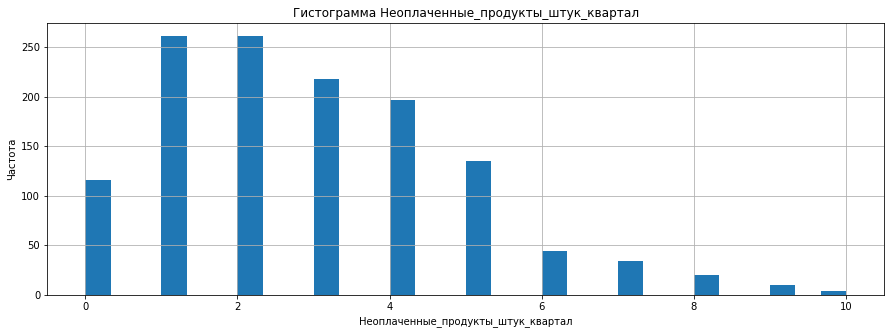

In [34]:
market_file['Неоплаченные_продукты_штук_квартал'].hist(bins=30, figsize=(15,5))
plt.title('Гистограмма Неоплаченные_продукты_штук_квартал')
plt.xlabel('Неоплаченные_продукты_штук_квартал')
plt.ylabel('Частота')
plt.show()

Гистограмма показывает распределение количества неоплаченных продуктов за квартал. Большинство значений сосредоточены в диапазоне от 1 до 4 продуктов, с медианным значением около 3. Наиболее часто встречающееся количество неоплаченных продуктов - около 3.

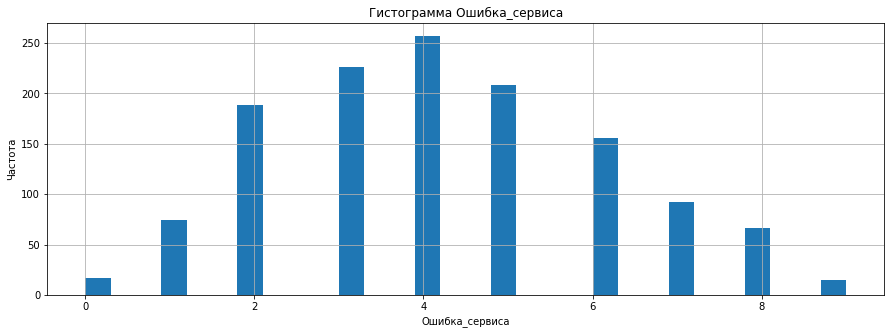

In [35]:
market_file['Ошибка_сервиса'].hist(bins=30, figsize=(15,5))
plt.title('Гистограмма Ошибка_сервиса')
plt.xlabel('Ошибка_сервиса')
plt.ylabel('Частота')
plt.show()

Гистограмма показывает распределение значений переменной "Ошибка_сервиса". Большинство значений сосредоточены в диапазоне от 0 до 9, с наиболее частыми значениями около 3, 4 и 6. Распределение симметрично, с плавным снижением частоты от центральных значений к минимальным и максимальным.

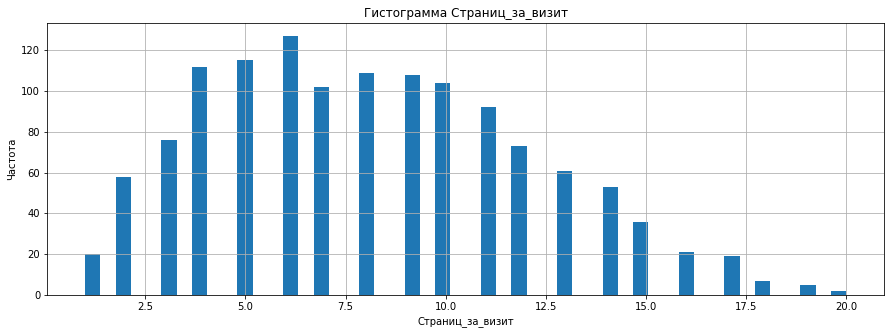

In [36]:
market_file['Страниц_за_визит'].hist(bins=50, figsize=(15,5))
plt.title('Гистограмма Страниц_за_визит')
plt.xlabel('Страниц_за_визит')
plt.ylabel('Частота')
plt.show()

Гистограмма показывает распределение значений переменной "Страниц_за_визит". Большинство значений сосредоточены в диапазоне от 1 до 20. Среднее количество страниц за визит составляет около 8, с отклонением от среднего примерно равным 4. Распределение имеет форму, близкую к нормальной, с пиком частоты около среднего значения и снижением частоты по мере удаления от него в обе стороны.

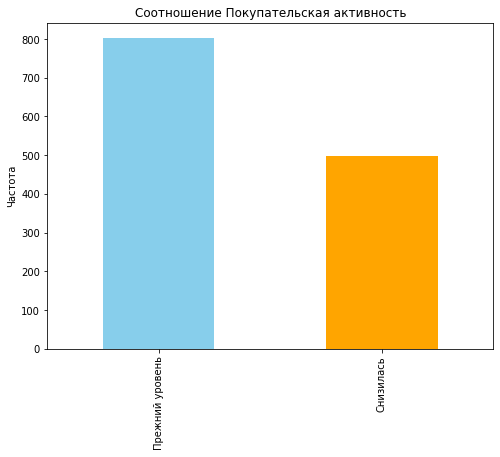

In [37]:
plt.figure(figsize=(8, 6))
market_file['Покупательская активность'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Cоотношение Покупательская активность')
plt.ylabel('Частота')
plt.show()

График показывает соотношение различных уровней покупательской активности. Большинство записей (802) отображают прежний уровень активности, в то время как у 498 записей наблюдается снижение активности.

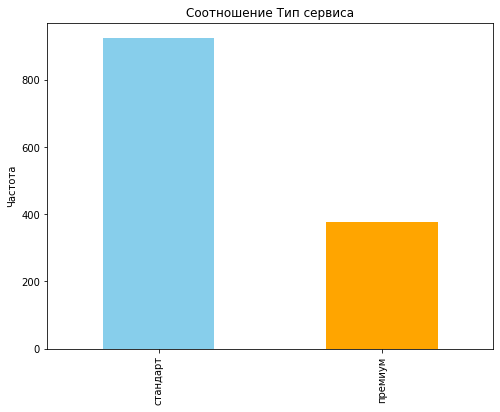

In [38]:
plt.figure(figsize=(8, 6))
market_file['Тип сервиса'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Cоотношение Тип сервиса')
plt.ylabel('Частота')
plt.show()

График демонстрирует соотношение различных типов сервиса. В данных преобладает стандартный сервис (924 записи), в то время как премиум сервис представлен в меньшем количестве (376 записей)

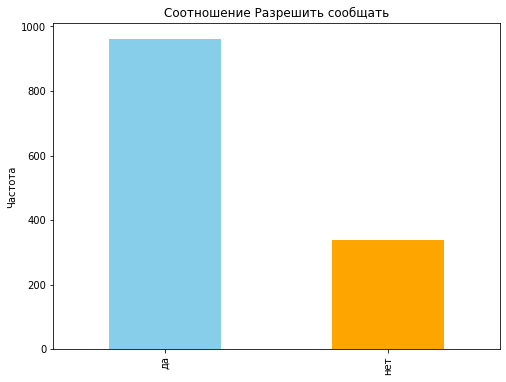

In [39]:
plt.figure(figsize=(8, 6))
market_file['Разрешить сообщать'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Cоотношение Разрешить сообщать')
plt.ylabel('Частота')
plt.show()


График иллюстрирует соотношение разрешений на отправку уведомлений. Большинство записей (962) предполагают разрешение на отправку уведомлений (да), в то время как 338 записей предполагают отсутствие такого разрешения (нет).

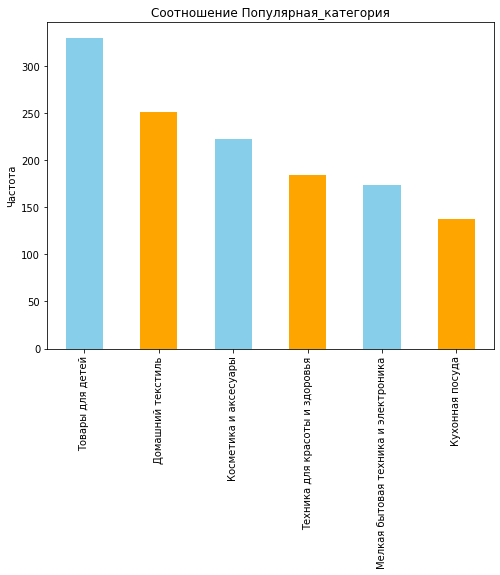

In [40]:
plt.figure(figsize=(8, 6))
market_file['Популярная_категория'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Cоотношение Популярная_категория')
plt.ylabel('Частота')
plt.show()


График отображает соотношение различных популярных категорий товаров. В данных преобладают категории "Товары для детей" (330 записей), "Домашний текстиль" (251 запись) и "Косметика и аксессуары" (223 записи). Остальные категории представлены в меньшем количестве. 

### market_money.csv¶

In [41]:
market_money.describe()

id        Выручка
count    3900.000000    3900.000000
mean   215997.500000    5025.696051
std       375.325686    1777.704104
min    215348.000000       0.000000
25%    215672.750000    4590.150000
50%    215997.500000    4957.500000
75%    216322.250000    5363.000000
max    216647.000000  106862.200000

In [42]:
(
    market_money
    .quantile([0.0012, 0.01, .5, .99, .9988]) # выбираем размах в 0,9976 квантилей 
    .style.format("{:,.2f}")
)

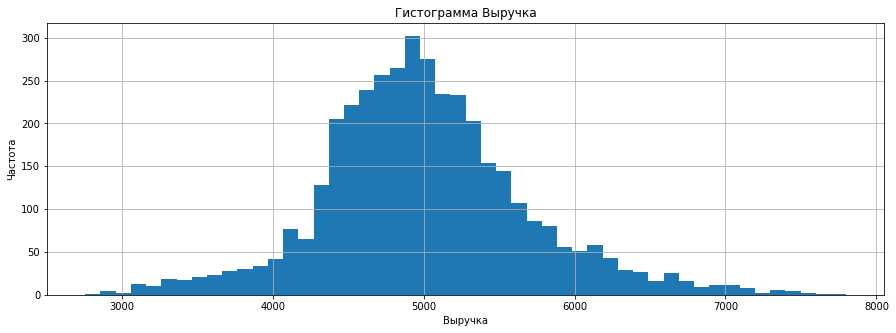

In [43]:
market_money['Выручка'] = market_money['Выручка'].drop(market_money[(market_money['Выручка'] > 8000)].index)
market_money['Выручка'] = market_money['Выручка'].drop(market_money[(market_money['Выручка'] < 2000)].index)
market_money['Выручка'].hist(bins=50, figsize=(15,5))
plt.title('Гистограмма Выручка')
plt.xlabel('Выручка')
plt.ylabel('Частота')
plt.show()

После удаления выбросов из данных о выручке, гистограмма показывает распределение значений выручки. Большинство значений сосредоточены в диапазоне от приблизительно 2758 до 7799.4. Среднее значение выручки составляет примерно 5007.28, с отклонением от среднего примерно равным 679.72. Распределение имеет форму, близкую к нормальной, с плавным спадом частоты от центральных значений к минимальным и максимальным.

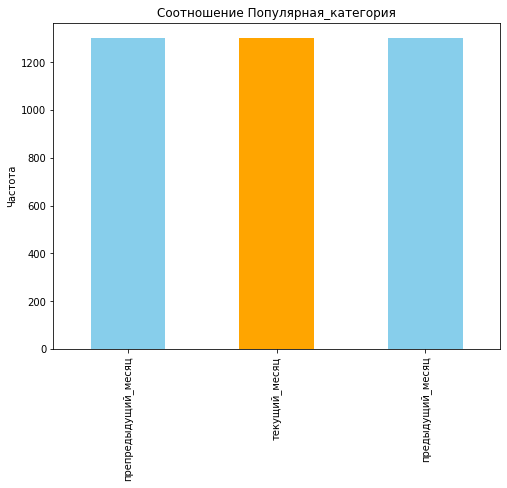

In [44]:
plt.figure(figsize=(8, 6))
market_money['Период'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Cоотношение Популярная_категория')
plt.ylabel('Частота')
plt.show()


График демонстрирует соотношение различных периодов данных. Каждый период (предыдущий месяц, текущий месяц, предпредыдущий месяц) содержит по 1300 записей. 

### market_time.csv

In [45]:
market_time.describe()

id        минут
count    2600.000000  2600.000000
mean   215997.500000    13.336154
std       375.349754     4.080198
min    215348.000000     4.000000
25%    215672.750000    10.000000
50%    215997.500000    13.000000
75%    216322.250000    16.000000
max    216647.000000    23.000000

In [46]:
(
    market_time
    .quantile([0.0012, 0.01, .5, .99, .9988]) # выбираем размах в 0,9976 квантилей 
    .style.format("{:,.2f}")
)

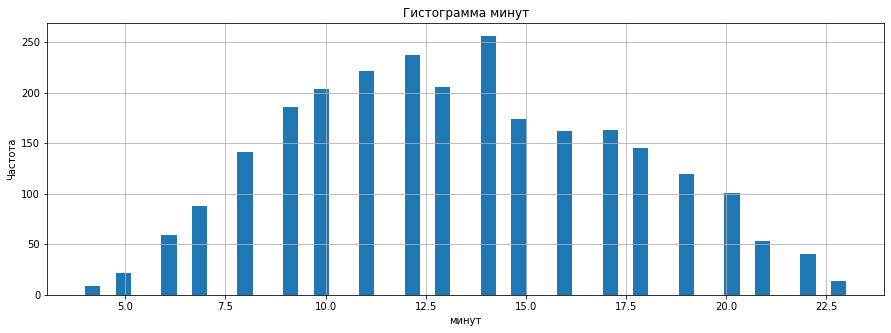

In [47]:
market_time['минут'].hist(bins=50, figsize=(15,5))
plt.title('Гистограмма минут')
plt.xlabel('минут')
plt.ylabel('Частота')
plt.show()

Гистограмма показывает распределение значений переменной "минут". Большинство значений сосредоточены в диапазоне от 4 до 23 минут. Среднее значение времени составляет около 13.34 минуты, со стандартным отклонением примерно равным 4.08. Распределение имеет форму, близкую к нормальной, с плавным снижением частоты от центральных значений к минимальным и максимальным.

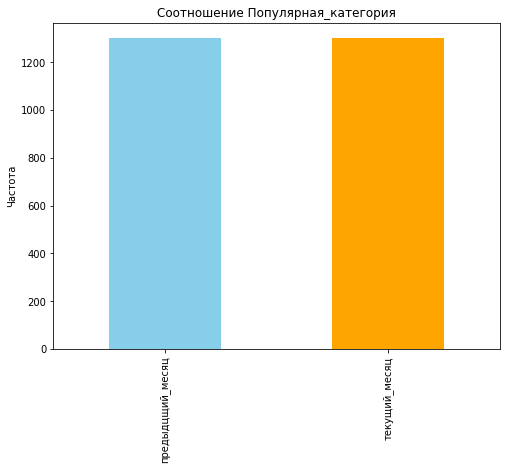

In [48]:
plt.figure(figsize=(8, 6))
market_time['Период'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Cоотношение Популярная_категория')
plt.ylabel('Частота')
plt.show()


В данных присутствуют два периода: "предыдущий месяц" и "текущий месяц", каждый из которых содержит по 1300 записей. График представлен в виде столбчатой диаграммы, где каждый столбец отражает один из периодов данных.

### money.csv

In [49]:
money.describe()

id      Прибыль
count    1300.000000  1300.000000
mean   215997.500000     3.996631
std       375.421985     1.013722
min    215348.000000     0.860000
25%    215672.750000     3.300000
50%    215997.500000     4.045000
75%    216322.250000     4.670000
max    216647.000000     7.430000

In [50]:
(
    money
    .quantile([0.0012, 0.01, .5, .99, .9988]) # выбираем размах в 0,9976 квантилей 
    .style.format("{:,.2f}")
)

In [51]:
money['Прибыль'].describe()

count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: Прибыль, dtype: float64

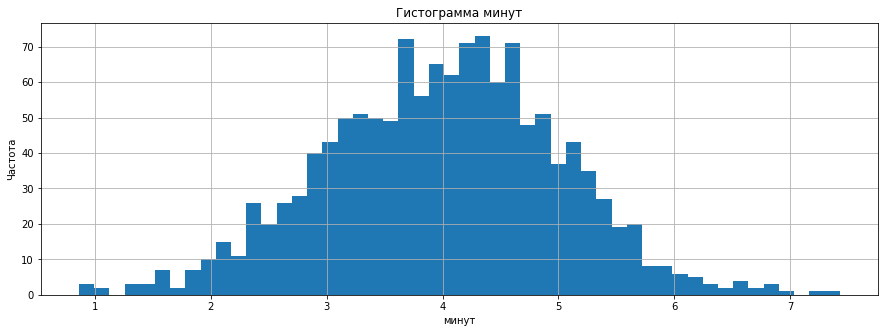

In [52]:
money['Прибыль'].hist(bins=50, figsize=(15,5))
plt.title('Гистограмма минут')
plt.xlabel('минут')
plt.ylabel('Частота')
plt.show()

Гистограмма показывает распределение значений переменной "Прибыль". Большинство значений сосредоточены в диапазоне от 0.86 до 7.43. Средняя прибыль составляет примерно 3.99, со стандартным отклонением около 1.01. Распределение прибыли имеет форму, близкую к нормальной, с плавным снижением частоты от центральных значений к минимальным и максимальным.

## Объединение таблиц

In [53]:
market_money_pivot = market_money.pivot_table(index='id', columns='Период', values='Выручка').reset_index()
market_time_pivot = market_time.pivot_table(index='id', columns='Период', values='минут').reset_index()

merged_data = pd.merge(market_file, market_money_pivot, on='id', how='left')
merged_data = pd.merge(merged_data, market_time_pivot, on='id', how='left')

merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 0 to 1299
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [54]:
merged_data.head()

id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась    стандарт                нет   
3  215351                 Снизилась    стандарт                 да   
4  215352                 Снизилась    стандарт                нет   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   
4     Товары для детей                                    3   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  \
0                                   2               1                 5   
1                                   4               2                 5   
2                                   2               1                 5   
3                                   0               6                 4   
4                                   2               3                 2   

   предыдущий_месяц  препредыдущий_месяц  текущий_месяц_x  предыдцщий_месяц  \
0               NaN                  NaN           3293.1                13   
1            5216.0               4472.0           4971.6                12   
2            5457.5               4826.0           5058.4                 8   
3            6158.0               4793.0           6610.4                11   
4            5807.5               4594.0           5872.5                 8   

   текущий_месяц_y  
0               14  
1               10  
2               13  
3               13  
4               11

In [55]:
active_clients = merged_data.loc[(merged_data['текущий_месяц_x'] > 0) &
                                 (merged_data['предыдущий_месяц'] > 0) &
                                 (merged_data['препредыдущий_месяц'] > 0)]

# Вывести результаты фильтрации
active_clients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 1 to 1299
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   Покупательская активность            1296 non-null   object 
 2   Тип сервиса                          1296 non-null   object 
 3   Разрешить сообщать                   1296 non-null   object 
 4   Маркет_актив_6_мес                   1296 non-null   float64
 5   Маркет_актив_тек_мес                 1296 non-null   int64  
 6   Длительность                         1296 non-null   int64  
 7   Акционные_покупки                    1296 non-null   float64
 8   Популярная_категория                 1296 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1296 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 11  Ошибка_сервиса                

**Вывод**

В результате объединения таблиц market_file.csv, market_money.csv и market_time.csv была создана новая таблица merged_data. В этой таблице содержатся данные о различных параметрах клиентов, включая их активность, тип сервиса, разрешение на уведомления, данные о продуктах и ошибках сервиса, а также информация о выручке и времени на сайте за различные периоды.

Для удобства анализа были созданы отдельные столбцы для каждого периода выручки и времени на сайте.

Далее была проведена фильтрация данных для поиска активных клиентов, которые показали положительную активность во всех трех периодах: предпредыдущий месяц, предыдущий месяц и текущий месяц. 

В результате фильтрации было получено 1296 активных клиентов. Эти данные могут быть использованы для дальнейшего анализа и принятия бизнес-решений, например, для разработки стратегии удержания клиентов или увеличения продаж.

## Корреляционный анализ

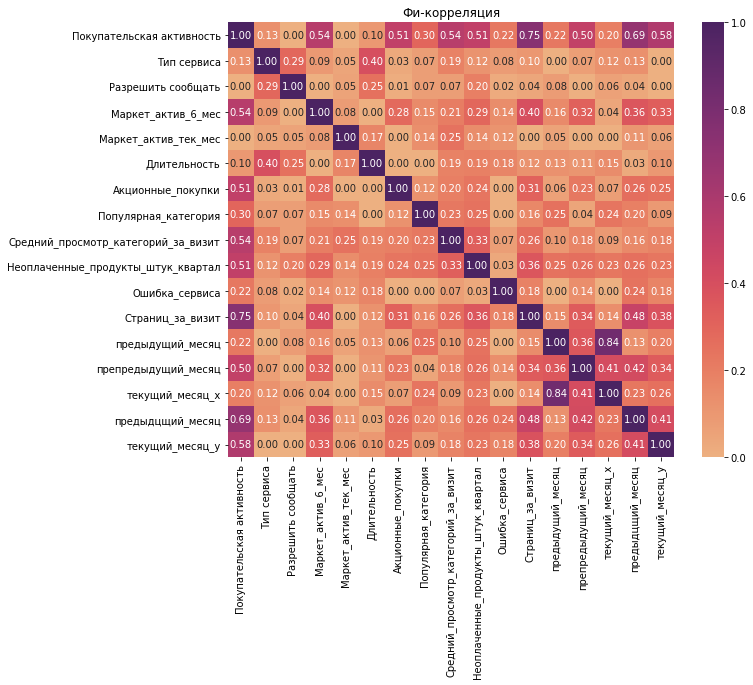

In [56]:
active_clients_subset = active_clients.drop(columns=['id'])
numerical_col_names = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'предыдущий_месяц', 'препредыдущий_месяц', 'текущий_месяц_x', 'предыдцщий_месяц', 'текущий_месяц_y']
categorical_corr = active_clients_subset.phik_matrix(interval_cols=numerical_col_names)
plt.figure(figsize=(10, 8)) 
sns.heatmap(categorical_corr, annot=True, cmap='flare', fmt=".2f")
plt.title('Фи-корреляция')
plt.show()

In [57]:
active_clients_subset['Покупательская активность'].value_counts()

Прежний уровень    802
Снизилась          494
Name: Покупательская активность, dtype: int64

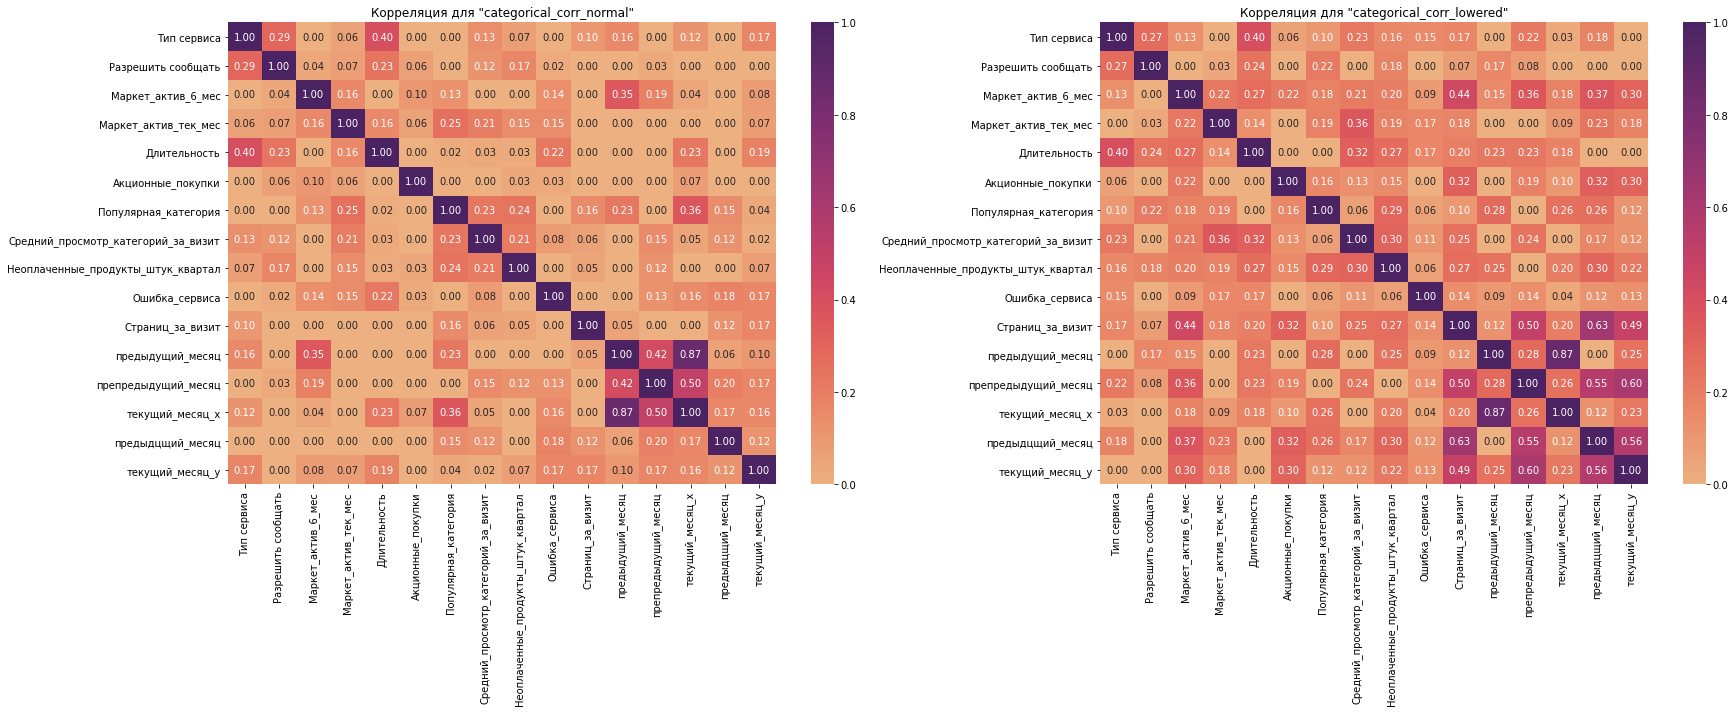

In [58]:
active_clients_subset_normal = active_clients_subset[active_clients_subset['Покупательская активность'] == 'Прежний уровень']
active_clients_subset_lowered = active_clients_subset[active_clients_subset['Покупательская активность'] == 'Снизилась']

categorical_corr_normal = active_clients_subset_normal.phik_matrix(interval_cols=numerical_col_names)
categorical_corr_lowered = active_clients_subset_lowered.phik_matrix(interval_cols=numerical_col_names)

plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
sns.heatmap(categorical_corr_normal, annot=True, cmap='flare', fmt=".2f")
plt.title('Корреляция для "categorical_corr_normal"')
plt.subplot(1, 2, 2)
sns.heatmap(categorical_corr_lowered, annot=True, cmap='flare', fmt=".2f")
plt.title('Корреляция для "categorical_corr_lowered"')
plt.tight_layout()
plt.show()

<Figure size 1440x720 with 0 Axes>

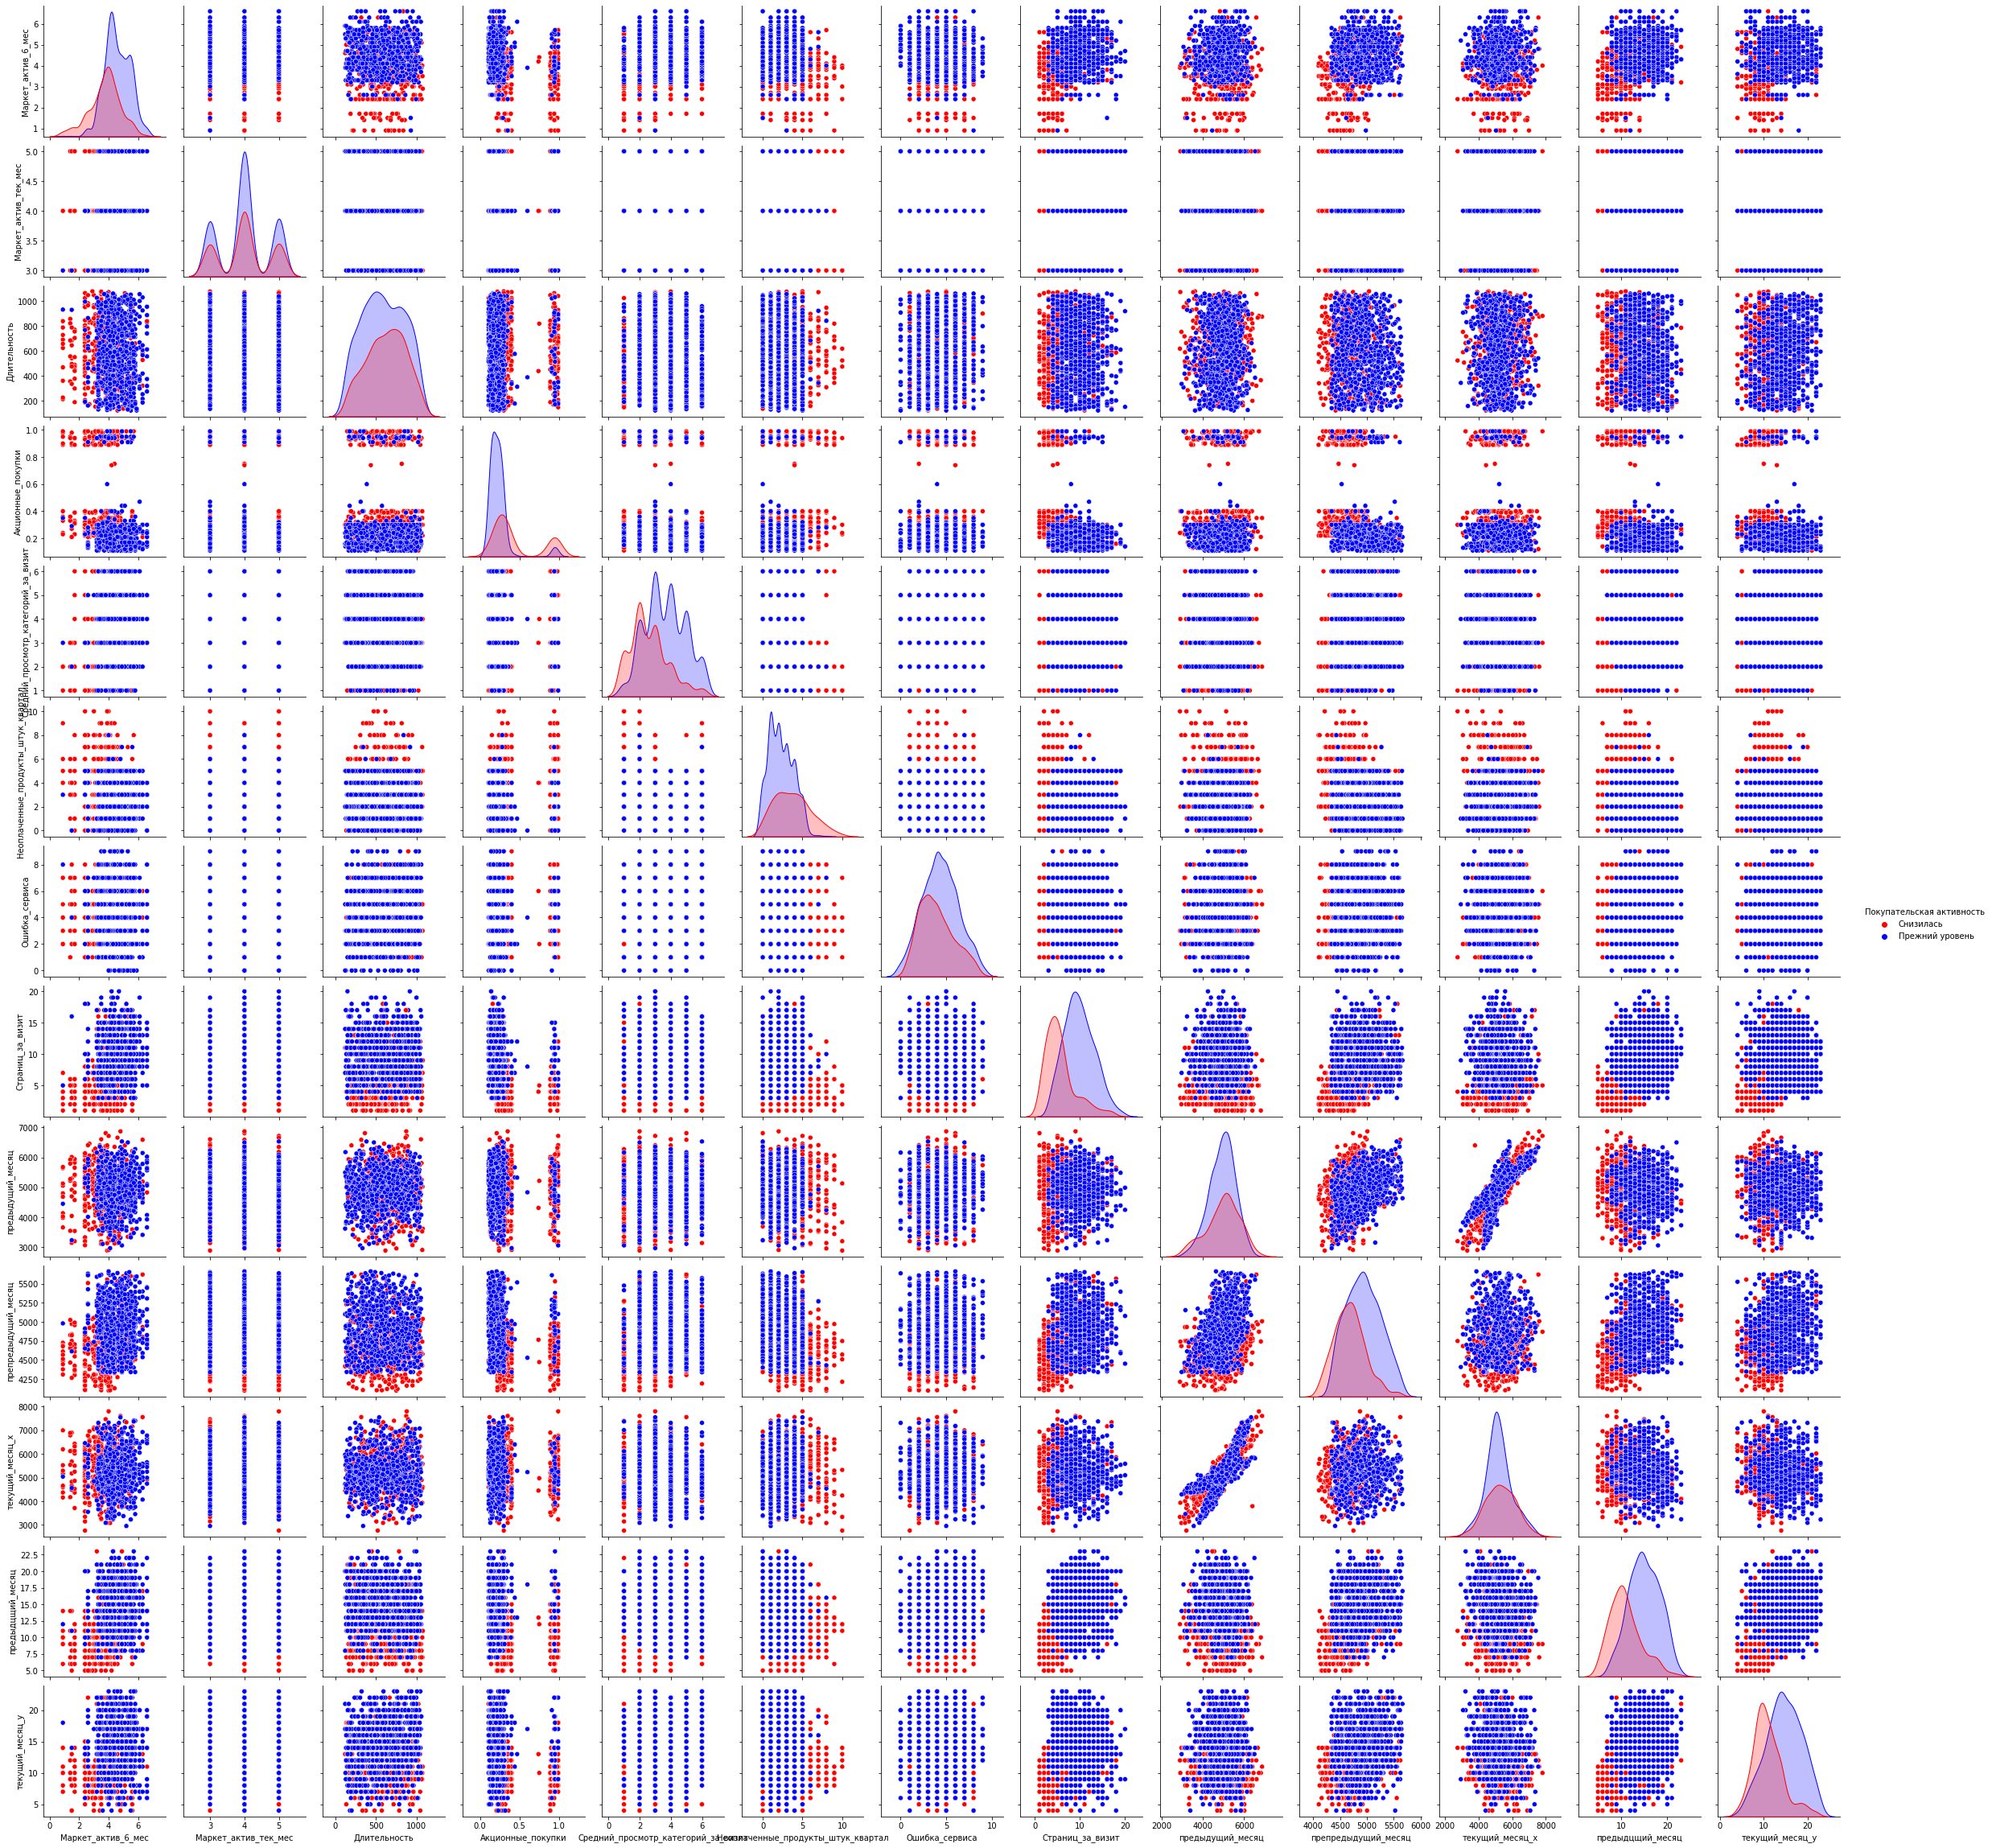

In [59]:
numerical_col_names = ['Покупательская активность', 'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'предыдущий_месяц', 'препредыдущий_месяц', 'текущий_месяц_x', 'предыдцщий_месяц', 'текущий_месяц_y']
active_clients_sub = active_clients[numerical_col_names]
grouped = active_clients_sub.groupby('Покупательская активность')

# Создание графика
plt.figure(figsize=(20, 10))

# Цвета для каждой группы целевого признака
colors = {'Снизилась': 'red', 'Прежний уровень': 'blue'}

active_clients_sub['Color'] = active_clients_sub['Покупательская активность'].map(colors)

# Построение матрицы рассеяния с окрашиванием точек
sns.pairplot(active_clients_sub, hue='Покупательская активность', palette=colors)

# Отображение графика
plt.show()

По коэффициентам корреляции между признаками и целевой переменной (Покупательская активность), можно сделать следующие выводы:

Сильная положительная корреляция (0.75) c признаком 'cтраниц_за_визит', показывает влияние того, что среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца вляет на покупательскую активность.

Умеренная положительная корреляция (~0.5) между целевым и признаками 'Средний_просмотр_категорий_за_визит', 'Акционные_покупки', 'Маркет_актив_6_мес', 'Неоплаченные_продукты_штук_квартал', 'Выручка'

При анализе графиков было обнаружено, что нет чёткой границы между снижением покупательской активности (красные кружки) и преждним уровнем (синие кружки). Наблюдается необычная комбинация значений целевого признака, что может затруднить обучение линейной модели. Такие аномальные значения представлены среди большого количества обычных значений, что делает их сложными для предсказания. Это явление следует учитывать при разработке модели и оценке её качества. Вероятно, для улучшения качества модели необходимо применить дополнительные методы обработки данных или использовать альтернативные алгоритмы машинного обучения, способные лучше учитывать подобные нестандартные комбинации признаков.

Мультиколлинеарность, при которой коэффициенты корреляции между признаками больше 0.9 не наблюдается.

##  Использование пайплайнов¶

In [60]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
    active_clients.drop(['Покупательская активность', 'id'], axis=1),
    active_clients['Покупательская активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = active_clients['Покупательская активность'])

X_train.shape, X_test.shape

((972, 16), (324, 16))

In [61]:
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [62]:
ohe_columns = ['Тип сервиса', 'Разрешить сообщать', 'Популярная_категория']
num_columns = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки',
               'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал',
               'Ошибка_сервиса', 'Страниц_за_визит', 'предыдущий_месяц', 'препредыдущий_месяц',
               'текущий_месяц_x', 'предыдцщий_месяц', 'текущий_месяц_y']

In [63]:
ohe_pipe = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

In [64]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [65]:
data_preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('simpleImputer_ohe',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['Тип сервиса', 'Разрешить сообщать',
                                  'Популярная_категория']),
                                ('num', MinMaxScaler(),
                                 ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес',
                                  'Длительность', 'Акционные_покупки',
                                  'Средний_просмотр_категорий_за_визит',
                                  'Неоплаченные_продукты_штук_квартал',
                                  'Ошибка_сервиса', 'Страниц_за_визит',
                                  'предыдущий_месяц', 'препредыдущий_месяц',
                                  'текущий_месяц_x', 'предыдцщий_месяц',
                                  'текущий_месяц_y'])])

In [66]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [67]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__ohe': [OneHotEncoder(), OrdinalEncoder()]  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__ohe': [OneHotEncoder()]   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'models__class_weight': ['balanced'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__ohe': [OneHotEncoder()]   
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE)],
        'models__class_weight': ['balanced'],
        'models__C': range(1, 5),
        'models__probability': [True],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__ohe': [OneHotEncoder(), OrdinalEncoder()]  
    },
]

Нам необходимо оценить качество работы модели вне зависимости от выбранного порога вероятности, поэтому тут мы используем метрику ROC_AUC. Метрику можно использовать в случае, когда объектов с одним значением целевого признака больше, чем с другими, что подтверждается дисбалансом классов в нашем целевом признаке. Как было показано в соотношении различных уровней покупательской активности, большинство записей (802) отображают прежний уровень активности, в то время как у 498 записей наблюдается снижение активности. Дисбаланс налицо.

In [68]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe', OrdinalEncoder(),
                                                  ['Тип сервиса',
                                                   'Разрешить сообщать',
                                                   'Популярная_категория']),
                                                 ('num', MinMaxScaler(),
                                                  ['Маркет_актив_6_мес',
                                                   'Маркет_актив_тек_мес',
                                                   'Длительность',
                                                   'Акционные_покупки',
                                                   'Средний_просмотр_категорий_за_визит',
                                                   'Неоплаченные_продукты_штук_квартал',
                                             

In [69]:
probabilities = randomized_search.predict_proba(X_test)
probabilities_one = probabilities[:, 1]
print('Метрика ROC-AUC на тестовой выборке:', roc_auc_score(y_test, probabilities_one))

Метрика ROC-AUC на тестовой выборке: 0.9151397484124095


**Вывод**

После проведения анализа и обучения моделей машинного обучения на основе данных о клиентах была выявлена лучшая модель, а именно, модель опорных векторов (SVC) с параметрами C=2, class_weight='balanced' и использованием вероятностной оценки (probability=True). 

Метрика ROC-AUC на тренировочной выборке для лучшей модели составила 0.8976, что говорит о хорошем качестве модели на тренировочных данных.

Для оценки качества модели на тестовой выборке была использована метрика ROC-AUC, которая показала значение 0.9151. Это свидетельствует о высокой предсказательной способности модели на новых, ранее не виданных данных.

Таким образом, модель SVC с выбранными параметрами может быть использована для прогнозирования покупательской активности клиентов с высокой точностью.

## Анализ важности признаков

PermutationExplainer explainer: 325it [05:29,  1.04s/it]                         


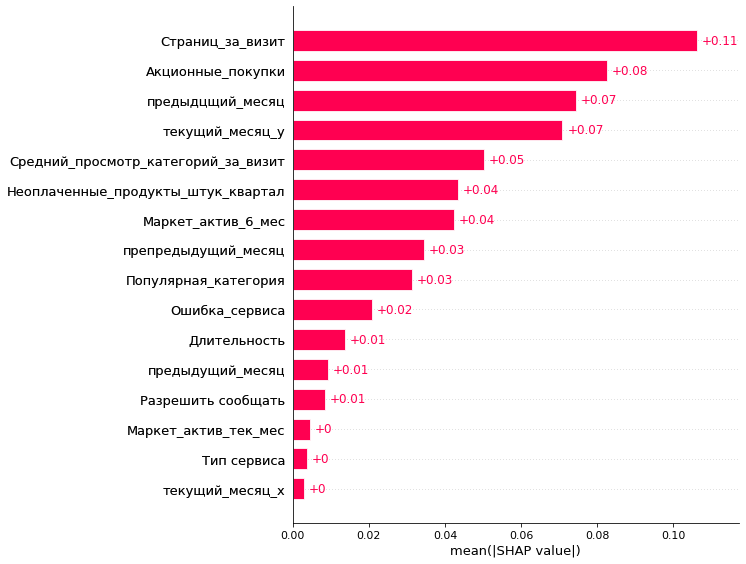

In [70]:
best_preprocessor = randomized_search.best_estimator_['preprocessor']

X_train_transformed = best_preprocessor.transform(X_train)
X_test_transformed = best_preprocessor.transform(X_test)

ohe_names = best_preprocessor.named_transformers_['ohe'].get_feature_names_out(input_features=ohe_columns)
num_names = num_columns

# Собираем все имена признаков
feature_names = np.concatenate([ohe_names, num_names])
explainer = shap.Explainer(randomized_search.best_estimator_['models'].predict, X_train_transformed,
                           feature_names=feature_names)
shap_values = explainer(X_test_transformed) 
shap.plots.bar(shap_values, max_display=17)

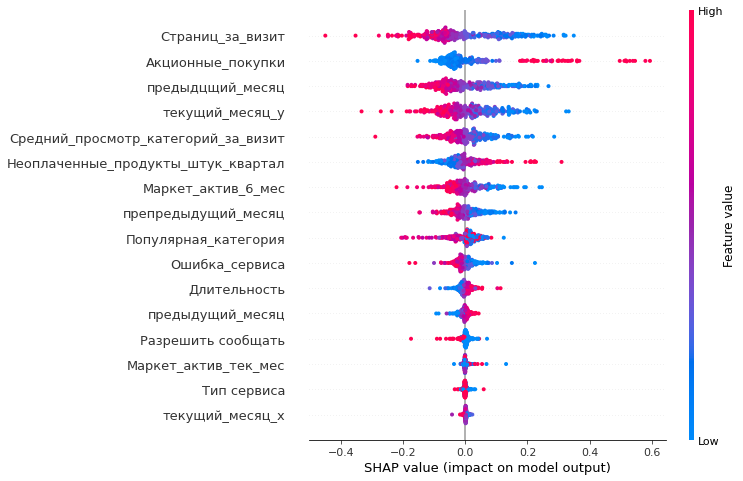

In [71]:
shap.plots.beeswarm(shap_values, max_display=17)

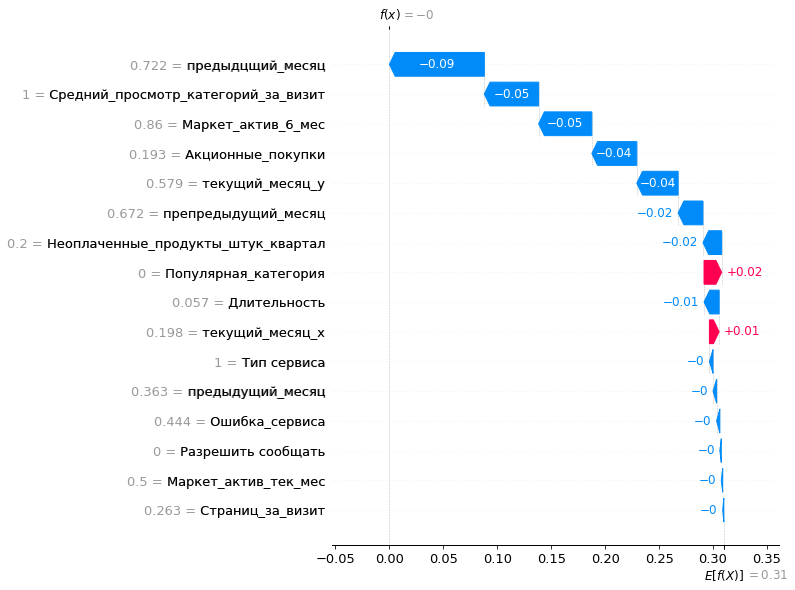

In [72]:
shap.plots.waterfall(shap_values[5], max_display=17)

**Вывод**

Из анализа важности признаков с использованием SHAP (SHapley Additive exPlanations) следует несколько ключевых выводов:

1. **Наиболее влиятельные признаки**: Важность признаков была оценена с использованием SHAP, и наиболее влиятельные признаки были определены как:
   - Страниц_за_визит
   - Акционные покупки
   - Предыдущий_месяц
   - Текущий месяц у
   - Средний просмотр_категорий_за_визит

2. **Влияние признаков на предсказание**: Высокие значения этих признаков обычно приводят к более высоким предсказаниям модели, тогда как низкие значения склонны уменьшать предсказания.

3. **Интерпретация важных признаков**:
   - **Страниц_за_визит**: Чем больше страниц посещает пользователь, тем выше его прогнозируемый результат.
   - **Акционные покупки**: Совершение акционных покупок увеличивает прогнозируемый результат.
   - **Предыдущий месяц** и **Текущий месяц у**: Значения из предыдущего и текущего месяцев могут влиять на прогнозируемый результат.
   - **Средний просмотр категорий за визит**: Чем больше категорий просматривает пользователь за визит, тем выше его прогнозируемый результат.

4. **Ограничения**: Важно помнить, что график SHAP не показывает взаимодействия между признаками, а также для более точной интерпретации результатов необходимо учитывать контекст задачи.


## Сегментация покупателей

In [73]:
predicted_labels = randomized_search.predict(active_clients.drop(['Покупательская активность', 'id'], axis=1))
active_clients['Предсказанная активность'] = label_encoder.inverse_transform(predicted_labels)
segmentation_data = active_clients.merge(money, on='id')
segmentation_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 0 to 1295
Data columns (total 20 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   Покупательская активность            1296 non-null   object 
 2   Тип сервиса                          1296 non-null   object 
 3   Разрешить сообщать                   1296 non-null   object 
 4   Маркет_актив_6_мес                   1296 non-null   float64
 5   Маркет_актив_тек_мес                 1296 non-null   int64  
 6   Длительность                         1296 non-null   int64  
 7   Акционные_покупки                    1296 non-null   float64
 8   Популярная_категория                 1296 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1296 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 11  Ошибка_сервиса                

In [74]:
segmentation_data.head()

id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215349                 Снизилась     премиум                 да   
1  215350                 Снизилась    стандарт                нет   
2  215351                 Снизилась    стандарт                 да   
3  215352                 Снизилась    стандарт                нет   
4  215353                 Снизилась    стандарт                 да   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                 4.4                     4           819               0.75   
1                 4.9                     3           539               0.14   
2                 3.2                     5           896               0.99   
3                 5.1                     3          1064               0.94   
4                 3.3                     4           762               0.26   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    4   
1    Домашний текстиль                                    5   
2     Товары для детей                                    5   
3     Товары для детей                                    3   
4    Домашний текстиль                                    4   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  \
0                                   4               2                 5   
1                                   2               1                 5   
2                                   0               6                 4   
3                                   2               3                 2   
4                                   1               1                 4   

   предыдущий_месяц  препредыдущий_месяц  текущий_месяц_x  предыдцщий_месяц  \
0            5216.0               4472.0           4971.6                12   
1            5457.5               4826.0           5058.4                 8   
2            6158.0               4793.0           6610.4                11   
3            5807.5               4594.0           5872.5                 8   
4            4738.5               5124.0           5388.5                10   

   текущий_месяц_y Предсказанная активность  Прибыль  
0               10                Снизилась     4.16  
1               13                Снизилась     3.13  
2               13                Снизилась     4.87  
3               11                Снизилась     4.21  
4               10                Снизилась     3.95

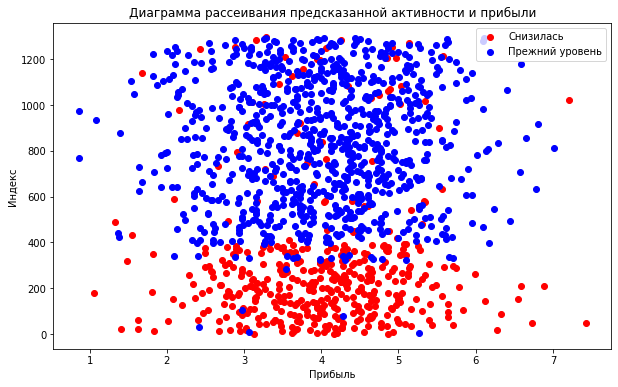

In [75]:
reduced_activity = segmentation_data[segmentation_data['Предсказанная активность'] == 'Снизилась']
previous_activity = segmentation_data[segmentation_data['Предсказанная активность'] == 'Прежний уровень']

plt.figure(figsize=(10, 6))
plt.scatter(reduced_activity['Прибыль'], reduced_activity.index, color='red', label='Снизилась')
plt.scatter(previous_activity['Прибыль'], previous_activity.index, color='blue', label='Прежний уровень')
plt.xlabel('Прибыль')
plt.ylabel('Индекс')
plt.title('Диаграмма рассеивания предсказанной активности и прибыли')
plt.legend()
plt.show()

In [76]:
lowered_activity = segmentation_data[segmentation_data['Предсказанная активность'] == 'Снизилась']
same_activity = segmentation_data[segmentation_data['Предсказанная активность'] == 'Прежний уровень']
lowered_activity.head()

id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215349                 Снизилась     премиум                 да   
1  215350                 Снизилась    стандарт                нет   
2  215351                 Снизилась    стандарт                 да   
3  215352                 Снизилась    стандарт                нет   
4  215353                 Снизилась    стандарт                 да   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                 4.4                     4           819               0.75   
1                 4.9                     3           539               0.14   
2                 3.2                     5           896               0.99   
3                 5.1                     3          1064               0.94   
4                 3.3                     4           762               0.26   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    4   
1    Домашний текстиль                                    5   
2     Товары для детей                                    5   
3     Товары для детей                                    3   
4    Домашний текстиль                                    4   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  \
0                                   4               2                 5   
1                                   2               1                 5   
2                                   0               6                 4   
3                                   2               3                 2   
4                                   1               1                 4   

   предыдущий_месяц  препредыдущий_месяц  текущий_месяц_x  предыдцщий_месяц  \
0            5216.0               4472.0           4971.6                12   
1            5457.5               4826.0           5058.4                 8   
2            6158.0               4793.0           6610.4                11   
3            5807.5               4594.0           5872.5                 8   
4            4738.5               5124.0           5388.5                10   

   текущий_месяц_y Предсказанная активность  Прибыль  
0               10                Снизилась     4.16  
1               13                Снизилась     3.13  
2               13                Снизилась     4.87  
3               11                Снизилась     4.21  
4               10                Снизилась     3.95

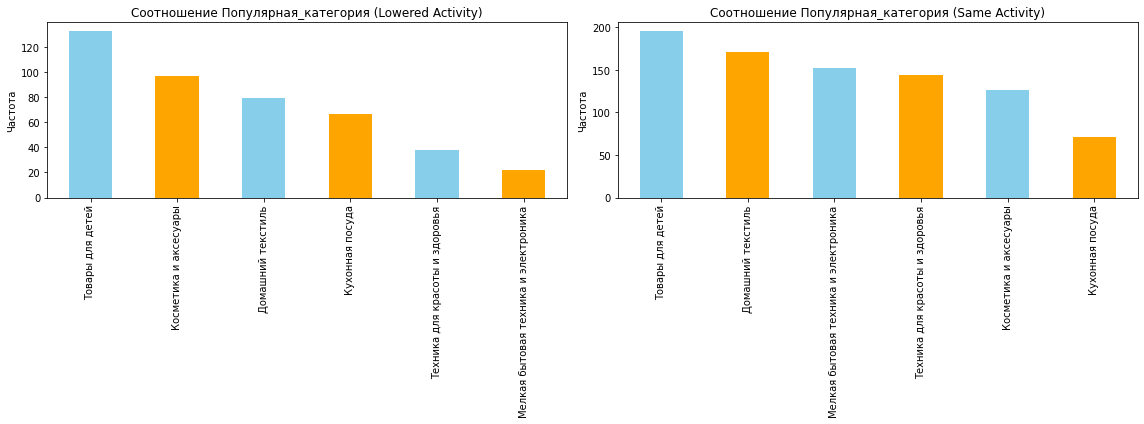

In [77]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

lowered_activity['Популярная_категория'].value_counts().plot(kind='bar', color=['skyblue', 'orange'], ax=axs[0])
axs[0].set_title('Cоотношение Популярная_категория (Lowered Activity)')
axs[0].set_ylabel('Частота')

same_activity['Популярная_категория'].value_counts().plot(kind='bar', color=['skyblue', 'orange'], ax=axs[1])
axs[1].set_title('Cоотношение Популярная_категория (Same Activity)')
axs[1].set_ylabel('Частота')

plt.tight_layout()
plt.show()

Ключевые выводы

Клиенты, чья активность, как прогнозируется, снизится, с большей вероятностью будут интересоваться товарами для детей и домашним текстилем.
Клиенты, чья активность, как прогнозируется, останется прежней, с большей вероятностью будут интересоваться косметикой и аксессуарами и мелкой бытовой техникой и электроникой.

Конкретные рекомендации

Направьте таргетированные маркетинговые кампании на товары для детей и домашний текстиль клиентам, чья активность, как прогнозируется, снизится.

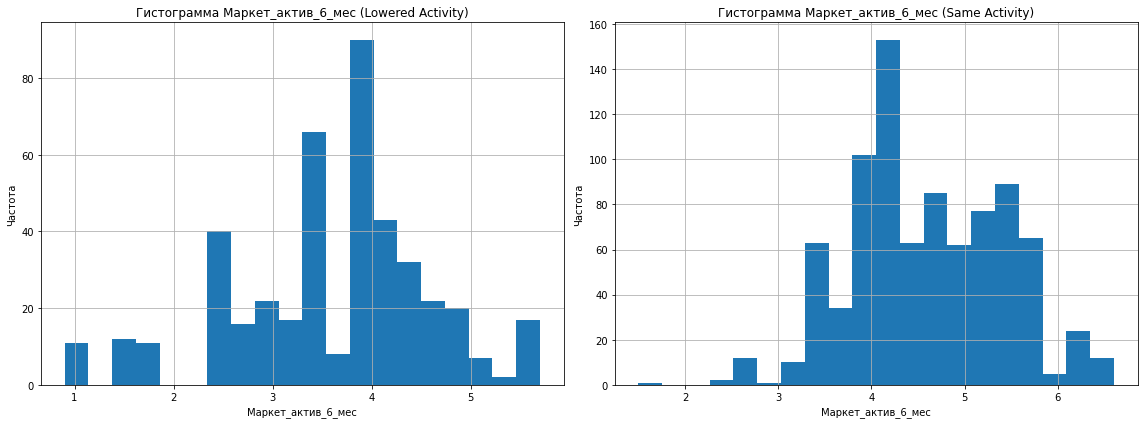

In [78]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
lowered_activity['Маркет_актив_6_мес'].hist(bins=20, ax=axs[0])
axs[0].set_title('Гистограмма Маркет_актив_6_мес (Lowered Activity)')
axs[0].set_xlabel('Маркет_актив_6_мес')
axs[0].set_ylabel('Частота')
same_activity['Маркет_актив_6_мес'].hist(bins=20, ax=axs[1])
axs[1].set_title('Гистограмма Маркет_актив_6_мес (Same Activity)')
axs[1].set_xlabel('Маркет_актив_6_мес')
axs[1].set_ylabel('Частота')
plt.tight_layout()
plt.show()

Клиенты, чья активность, как прогнозируется, снизится, в целом имеют более низкую среднюю активность на маркетплейсе за последние 6 месяцев, по сравнению с клиентами, чья активность, как прогнозируется, останется прежней.
Распределение активности на маркетплейсе среди клиентов с пониженной активностью более равномерное.

Рекомендации

Использовать данные о средней активности на маркетплейсе для разработки маркетинговых кампаний, направленных на повышение активности клиентов.
Разработать специальные программы лояльности или программы поощрения для клиентов с пониженной активностью на маркетплейсе.
Проводить опросы клиентов, чтобы понять причины снижения активности на маркетплейсе.

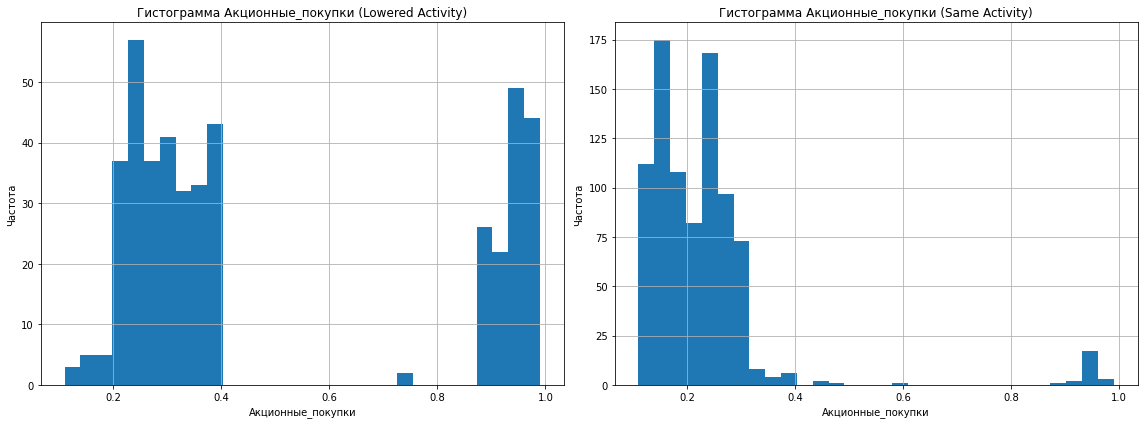

In [79]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
lowered_activity['Акционные_покупки'].hist(bins=30, ax=axs[0])
axs[0].set_title('Гистограмма Акционные_покупки (Lowered Activity)')
axs[0].set_xlabel('Акционные_покупки')
axs[0].set_ylabel('Частота')
same_activity['Акционные_покупки'].hist(bins=30, ax=axs[1])
axs[1].set_title('Гистограмма Акционные_покупки (Same Activity)')
axs[1].set_xlabel('Акционные_покупки')
axs[1].set_ylabel('Частота')
plt.tight_layout()
plt.show()

Гистограммы показывают, что существует явное различие в распределении количества покупок по акциям между клиентами, чья активность, как прогнозируется, снизится, и клиентами, чья активность, как прогнозируется, останется прежней. 

Клиенты, чья активность, как прогнозируется, снизится, с большей вероятностью будут совершать больше покупок по акциям.
Клиенты, чья активность, как прогнозируется, останется прежней, с большей вероятностью будут совершать меньше покупок по акциям.

Конкретные рекомендации

Направьте таргетированные маркетинговые кампании на акционные товары клиентам, чья активность, как прогнозируется, снизится.
Направьте таргетированные маркетинговые кампании на товары, не являющиеся акционными, клиентам, чья активность, как прогнозируется, останется прежней.

Дополнительные соображения

Важно отметить, что это лишь общие тенденции. Всегда будет наблюдаться некоторое совпадение между двумя группами.
Эффективность таргетированных маркетинговых кампаний будет зависеть от ряда факторов, таких как конкретные товары, которые продвигаются, и используемые сообщения.

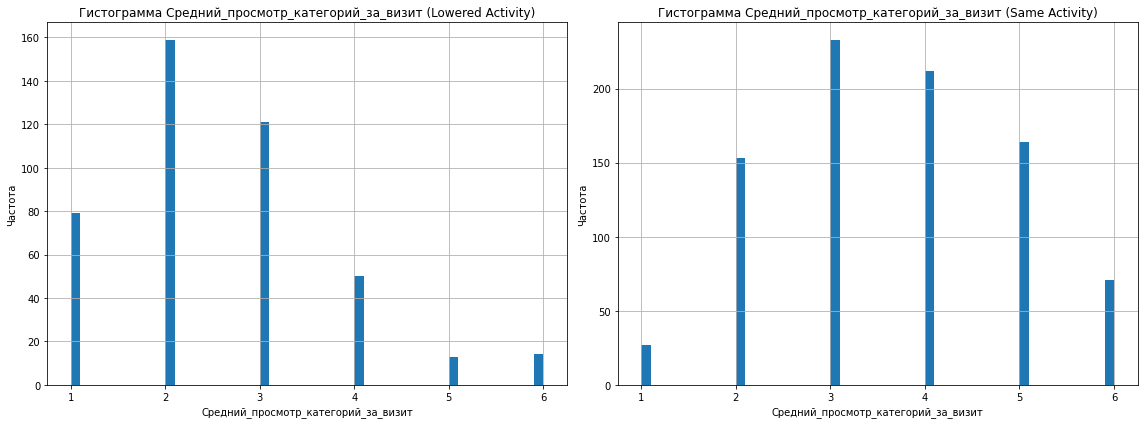

In [80]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
lowered_activity['Средний_просмотр_категорий_за_визит'].hist(bins=50, ax=axs[0])
axs[0].set_title('Гистограмма Средний_просмотр_категорий_за_визит (Lowered Activity)')
axs[0].set_xlabel('Средний_просмотр_категорий_за_визит')
axs[0].set_ylabel('Частота')
same_activity['Средний_просмотр_категорий_за_визит'].hist(bins=50, ax=axs[1])
axs[1].set_title('Гистограмма Средний_просмотр_категорий_за_визит (Same Activity)')
axs[1].set_xlabel('Средний_просмотр_категорий_за_визит')
axs[1].set_ylabel('Частота')
plt.tight_layout()
plt.show()

Клиенты, чья активность, как прогнозируется, снизится, с большей вероятностью будут просматривать меньше категорий товаров за один визит.

Клиенты, чья активность, как прогнозируется, останется прежней, с большей вероятностью будут просматривать больше категорий товаров за один визит.

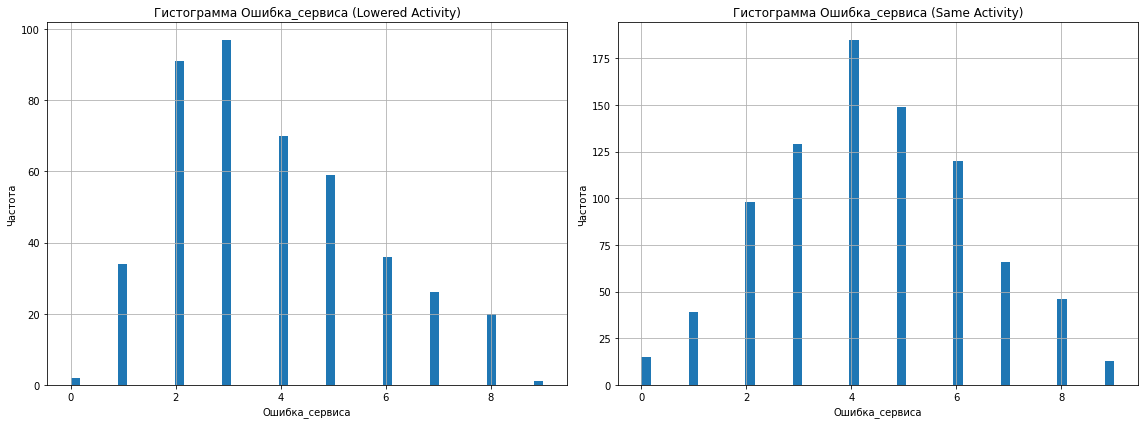

In [81]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
lowered_activity['Ошибка_сервиса'].hist(bins=50, ax=axs[0])
axs[0].set_title('Гистограмма Ошибка_сервиса (Lowered Activity)')
axs[0].set_xlabel('Ошибка_сервиса')
axs[0].set_ylabel('Частота')
same_activity['Ошибка_сервиса'].hist(bins=50, ax=axs[1])
axs[1].set_title('Гистограмма Ошибка_сервиса (Same Activity)')
axs[1].set_xlabel('Ошибка_сервиса')
axs[1].set_ylabel('Частота')
plt.tight_layout()
plt.show()

Ключевые выводы

У клиентов, чья активность, как прогнозируется, снизится, ошибки сервиса встречаются чаще, чем у клиентов, чья активность, как прогнозируется, останется прежней.
Распределение частоты ошибок сервиса у клиентов с пониженной активностью более равномерное.

Рекомендации

Провести более детальный анализ причин ошибок сервиса у клиентов с пониженной активностью.
Разработать и внедрить меры по предотвращению ошибок сервиса у клиентов с пониженной активностью.
Отслеживать влияние мер по предотвращению ошибок сервиса на активность клиентов.

Дополнительные соображения

Важно отметить, что корреляция не означает причинно-следственную связь.
Возможно, что клиенты с пониженной активностью чаще сообщают об ошибках сервиса, чем клиенты с более высокой активностью.
Необходимо провести дальнейшие исследования, чтобы полностью понять взаимосвязь между ошибками сервиса и активностью клиентов.

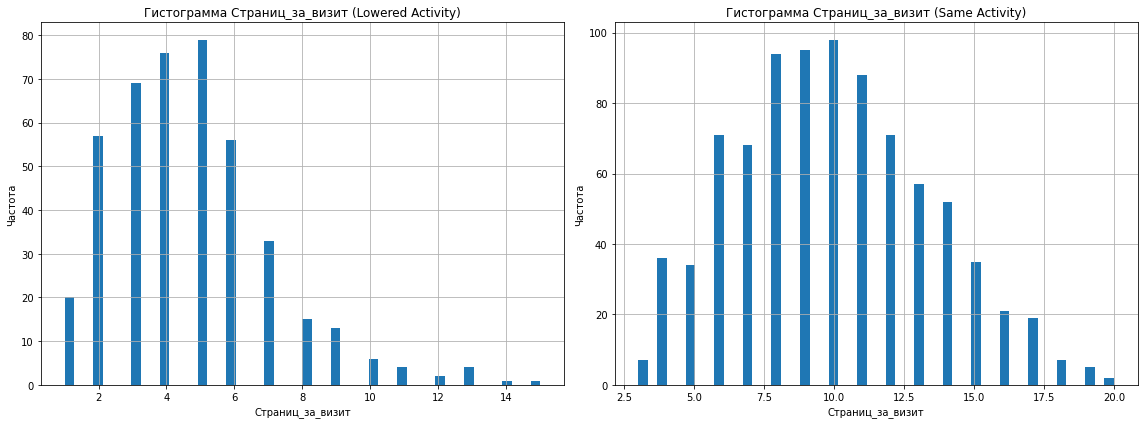

In [82]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
lowered_activity['Страниц_за_визит'].hist(bins=50, ax=axs[0])
axs[0].set_title('Гистограмма Страниц_за_визит (Lowered Activity)')
axs[0].set_xlabel('Страниц_за_визит')
axs[0].set_ylabel('Частота')
same_activity['Страниц_за_визит'].hist(bins=50, ax=axs[1])
axs[1].set_title('Гистограмма Страниц_за_визит (Same Activity)')
axs[1].set_xlabel('Страниц_за_визит')
axs[1].set_ylabel('Частота')
plt.tight_layout()
plt.show()

Ключевые выводы

Клиенты, чья активность, как прогнозируется, снизится, с большей вероятностью будут просматривать меньше страниц за один сеанс.
Клиенты, чья активность, как прогнозируется, останется прежней, с большей вероятностью будут просматривать больше страниц за один сеанс.

Конкретные рекомендации

Направьте таргетированные маркетинговые кампании на сайты с богатым контентом клиентам, чья активность, как прогнозируется, останется прежней.
Направьте таргетированные маркетинговые кампании на сайты с лаконичным и простым для навигации контентом клиентам, чья активность, как прогнозируется, снизится.

Дополнительные соображения

Важно отметить, что это лишь общие тенденции. Всегда будет наблюдаться некоторое совпадение между двумя группами.
Эффективность таргетированных маркетинговых кампаний будет зависеть от ряда факторов, таких как конкретные сайты, которые продвигаются, и используемые сообщения.

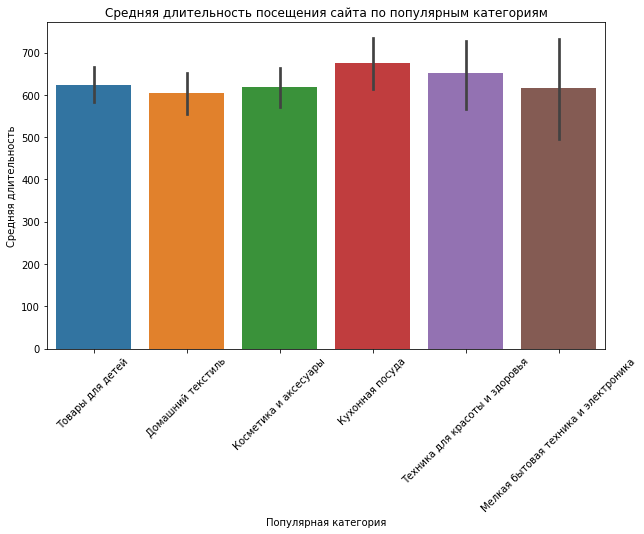

In [83]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Популярная_категория', y='Длительность', data=lowered_activity)
plt.title('Средняя длительность посещения сайта по популярным категориям')
plt.xlabel('Популярная категория')
plt.ylabel('Средняя длительность')
plt.xticks(rotation=45)
plt.show()

Данная диаграмма показывает, что существует связь между популярной категорией товаров и средней длительностью посещения сайта.

Рекомендации:

Использовать информацию о средней длительности посещения сайта для разработки маркетинговых стратегий.
Создавать контент и маркетинговые материалы, которые будут соответствовать интересам клиентов, просматривающих разные категории товаров.
Проводить дальнейшие исследования, чтобы более детально изучить связь между покупательским поведением и активностью клиентов.


In [84]:
lowered_activity = segmentation_data[(segmentation_data['Предсказанная активность'] == 'Снизилась') & (segmentation_data['Прибыль'] >= 4)]
lowered_activity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 231 entries, 0 to 1284
Data columns (total 20 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   231 non-null    int64  
 1   Покупательская активность            231 non-null    object 
 2   Тип сервиса                          231 non-null    object 
 3   Разрешить сообщать                   231 non-null    object 
 4   Маркет_актив_6_мес                   231 non-null    float64
 5   Маркет_актив_тек_мес                 231 non-null    int64  
 6   Длительность                         231 non-null    int64  
 7   Акционные_покупки                    231 non-null    float64
 8   Популярная_категория                 231 non-null    object 
 9   Средний_просмотр_категорий_за_визит  231 non-null    int64  
 10  Неоплаченные_продукты_штук_квартал   231 non-null    int64  
 11  Ошибка_сервиса                 

In [85]:
avg_duration = lowered_activity['Длительность'].mean()
print(f"Средняя длительность посещения сайта для сегмента сниженной активности и высокой прибыли: {avg_duration}")


Средняя длительность посещения сайта для сегмента сниженной активности и высокой прибыли: 618.3636363636364


In [86]:
avg_unpaid_products = lowered_activity['Неоплаченные_продукты_штук_квартал'].mean()
print(f"Среднее количество неоплаченных продуктов в квартал для сегмента сниженной активности и высокой прибыли: {avg_unpaid_products}")

Среднее количество неоплаченных продуктов в квартал для сегмента сниженной активности и высокой прибыли: 3.9047619047619047


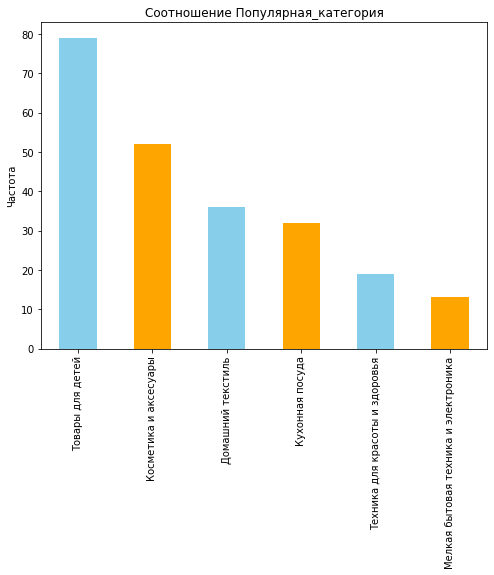

In [87]:
plt.figure(figsize=(8, 6))
lowered_activity['Популярная_категория'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Cоотношение Популярная_категория')
plt.ylabel('Частота')
plt.show()

Клиенты, чья активность, как прогнозируется, снизится, и чья прибыль составляет 4 рубля или более, имеют более низкую активность по сравнению с другими клиентами.

Средняя длительность посещения сайта для этого сегмента составляет 618.36 секунд, что ниже среднего.

Среднее количество неоплаченных продуктов в квартал для этого сегмента составляет 3.9047 штуки, что выше среднего.

Самая популярная категория товаров для этого сегмента - "Товары для детей".

Другие популярные категории: "Косметика и аксессуары", "Домашний текстиль", "Кухонная посуда", "Техника для красоты и здоровья", "Мелкая бытовая техника и электроника".

Рекомендации:

Разработать маркетинговые кампании, нацеленные на увеличение активности клиентов в этом сегменте.
Предложить скидки и акции на товары из категории "Товары для детей".
Улучшить качество обслуживания клиентов в этом сегменте.

## Общий вывод

#### Итоговый вывод по проекту

Проект по прогнозированию покупательской активности клиентов достиг следующих результатов:

**Лучшая модель** : SVC с параметрами C=2, class_weight='balanced' и probability=True.
ROC-AUC на тренировочной выборке: 0.8976.
ROC-AUC на тестовой выборке: 0.9151.
Анализ признаков:

**Наиболее влиятельные признаки** : Страниц_за_визит, Акционные покупки, Предыдущий_месяц, Текущий_месяц, Средний_просмотр_категорий_за_визит.

**Сегментация покупателей** :

* Клиенты с прогнозируемым снижением активности имеют тенденцию к более низкой прибыли.
* Клиенты с прогнозируемым снижением активности с большей вероятностью будут интересоваться товарами для детей и домашним текстилем.
* Клиенты с прогнозируемым снижением активности с большей вероятностью будут совершать больше покупок по акциям.
* Клиенты с прогнозируемым снижением активности с большей вероятностью будут просматривать меньше категорий товаров за один визит.
* Клиенты с прогнозируемым снижением активности с большей вероятностью будут просматривать меньше страниц за один сеанс.
* Клиенты с прогнозируемым снижением активности и чья прибыль составляет 4 рубля или более, имеют более низкую активность по сравнению с другими клиентами.

**Рекомендации** :

* Направьте таргетированные маркетинговые кампании на товары для детей и домашний текстиль клиентам, чья активность, как прогнозируется, снизится.
* Направьте таргетированные маркетинговые кампании на акционные товары клиентам, чья активность, как прогнозируется, снизится.
* Направьте таргетированные маркетинговые кампании на товары, не являющиеся акционными, клиентам, чья активность, как прогнозируется, останется прежней.
* Направьте таргетированные маркетинговые кампании на сайты с богатым контентом клиентам, чья активность, как прогнозируется, останется прежней.
* Направьте таргетированные маркетинговые кампании на сайты с лаконичным и простым для навигации контентом клиентам, чья активность, как прогнозируется, снизится.
* Разработать маркетинговые кампании, нацеленные на увеличение активности клиентов в сегменте с прогнозируемым снижением активности и прибылью 4 рубля или более.
* Предложить скидки и акции на товары из категории "Товары для детей" для клиентов с прогнозируемым снижением активности и прибылью 4 рубля или более.
* Улучшить качество обслуживания клиентов в сегменте с прогнозируемым снижением активности и прибылью 4 рубля или более.
* Использовать информацию о средней длительности посещения сайта для разработки маркетинговых стратегий.
* Создавать контент и маркетинговые материалы, которые будут соответствовать интересам клиентов, просматривающих разные категории товаров.
* Проводить дальнейшие исследования, чтобы более детально изучить связь между покупательским поведением и активностью клиентов.

**Ограничения** :

График SHAP не показывает взаимодействия между признаками.
Для более точной интерпретации результатов необходимо учитывать контекст задачи.
Корреляция не означает причинно-следственную связь.

**Следующие шаги** :

* Провести более детальный анализ причин ошибок сервиса у клиентов с пониженной активностью.
* Разработать и внедрить меры по предотвращению ошибок сервиса у клиентов с пониженной активностью.
* Отслеживать влияние мер по предотвращению ошибок сервиса на активность клиентов.
* Проводить дальнейшие исследования, чтобы более детально изучить связь между покупательским поведением и активностью клиентов.